In [44]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

Importo i dataset

In [45]:
csv_extension = ".csv"
pickle_extension = ".pickle"

data_folder_path = os.path.join('', 'data')
graphics_folder_path = os.path.join('', 'graphics')

lifts_file_name = 'lifts'
runs_file_name = 'runs'
ski_areas_file_name = 'ski_areas'

lifts_file_path = os.path.join(data_folder_path, str(lifts_file_name) + str(pickle_extension))
runs_file_path = os.path.join(data_folder_path, str(runs_file_name) + str(pickle_extension))
ski_areas_file_path = os.path.join(data_folder_path, str(ski_areas_file_name) + str(pickle_extension))

higher_slopes_distance_by_difficulty_path = os.path.join(graphics_folder_path, "higher_slopes_distance_by_difficulty.png")
lower_slopes_distance_by_difficulty_path = os.path.join(graphics_folder_path, "lower_slopes_distance_by_difficulty.png")
slopes_distance_by_lifts_number_path = os.path.join(graphics_folder_path, "slopes_distance_by_lifts_number.png")
higher_median_ski_area_length_by_country_path = os.path.join(graphics_folder_path, "higher_median_ski_area_length_by_country.png")
lower_median_ski_area_length_by_country_path = os.path.join(graphics_folder_path, "lower_median_ski_area_length_by_country.png")
max_difficulty_level_by_ski_area_elevation_path = os.path.join(graphics_folder_path, "max_difficulty_level_by_ski_area_elevation.png")
number_of_lifts_by_type_path = os.path.join(graphics_folder_path, "number_of_lifts_by_type.png")
number_of_lifts_by_type_coutry_with_bigger_areas_path = os.path.join(graphics_folder_path, "number_of_lifts_by_type_coutry_with_bigger_areas.png")
number_of_lifts_by_type_coutry_with_smaller_areas_path = os.path.join(graphics_folder_path, "number_of_lifts_by_type_coutry_with_smaller_areas.png")

difficulty_order = ["novice", "easy", "intermediate", "advanced", "expert", "extreme", "freeride"]

lifts = pd.read_pickle(lifts_file_path)
runs = pd.read_pickle(runs_file_path)
ski_areas = pd.read_pickle(ski_areas_file_path)

Qual è la distribuzione delle difficoltà delle piste nei paesi con più km di piste? E nei paesi con meno Km di piste?

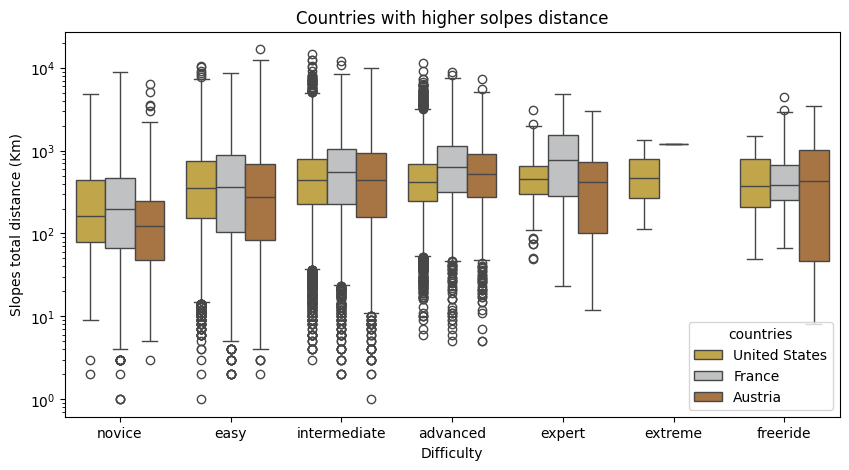

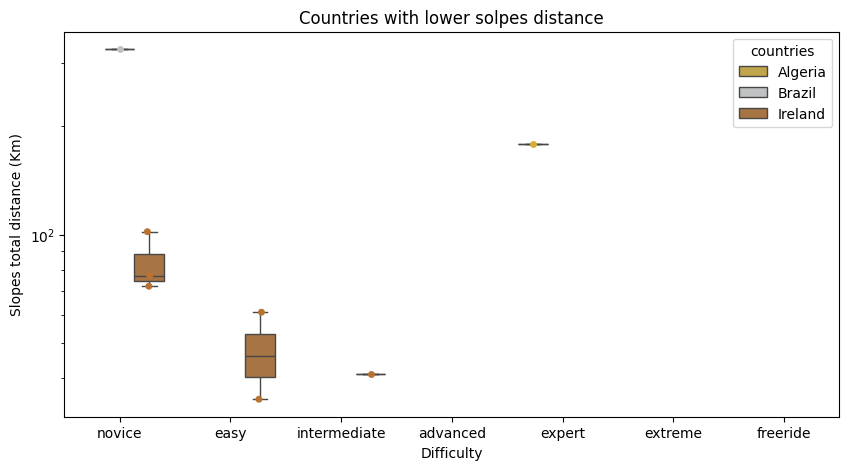

In [46]:
slopes_km_by_country = runs.groupby("countries")["inclined_length_m"].sum()

more_km_country = slopes_km_by_country.nlargest(3).index
less_km_country = slopes_km_by_country.nsmallest(3).index

more_slopes_km_countries = runs[runs["countries"].isin(more_km_country)][["countries", "difficulty", "inclined_length_m"]]
less_slopes_km_countries = runs[runs["countries"].isin(less_km_country)][["countries", "difficulty", "inclined_length_m"]]

palette = {more_km_country[0]: "#D4AF37", more_km_country[1]: "#BFC1C2", more_km_country[2]: "#B87333", less_km_country[0]: "#D4AF37", less_km_country[1]: "#BFC1C2", less_km_country[2]: "#B87333", }
hue_order_more_km = [country for country in more_km_country]
hue_order_less_km = [country for country in less_km_country]

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x="difficulty", y="inclined_length_m", hue="countries", data=more_slopes_km_countries, hue_order=hue_order_more_km, order=difficulty_order, log_scale=True, palette=palette)
plt.xlabel("Difficulty")
plt.ylabel("Slopes total distance (Km)")
plt.title("Countries with higher solpes distance")
plt.savefig(higher_slopes_distance_by_difficulty_path, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize = (10, 5))
sns.stripplot(x="difficulty", y="inclined_length_m", hue="countries", data=less_slopes_km_countries, hue_order=hue_order_less_km, order=difficulty_order, log_scale=True, palette=palette, dodge=True, legend=False)
sns.boxplot(x="difficulty", y="inclined_length_m", hue="countries", data=less_slopes_km_countries, hue_order=hue_order_less_km, order=difficulty_order, log_scale=True, palette=palette, dodge=True)
plt.xlabel("Difficulty")
plt.ylabel("Slopes total distance (Km)")
plt.title("Countries with lower solpes distance")
plt.savefig(lower_slopes_distance_by_difficulty_path, bbox_inches='tight')
plt.show()

Esiste una correlazione tra numero di impianti in un comprensorio e km di piste?

Spearman: 0.8924 with p=1.16e-131


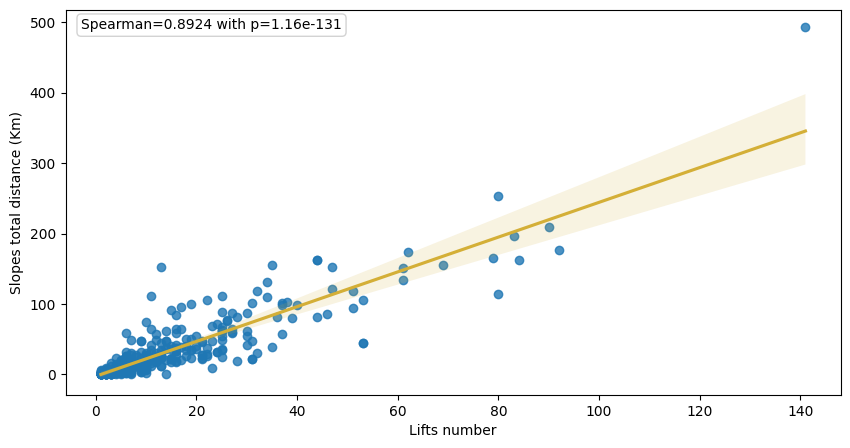

In [47]:
areas_distance = ski_areas[["lift_count", "downhill_distance_km"]]
corr_spearman = sp.stats.spearmanr(ski_areas["lift_count"], ski_areas["downhill_distance_km"])
print(f"Spearman: {corr_spearman[0]:.4f} with p={corr_spearman[1]:.2e}")

fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.regplot(data=ski_areas, x="lift_count", y="downhill_distance_km", line_kws=dict(color="#D4AF37"))
plt.xlabel("Lifts number")
plt.ylabel("Slopes total distance (Km)")
ax.annotate(f"Spearman={corr_spearman[0]:.4f} with p={corr_spearman[1]:.2e}", xy=(0.02, 0.96), xycoords='axes fraction', ha='left', va='center', bbox={'boxstyle': 'round', 'fc': 'white', 'ec': 'lightgrey'})
plt.savefig(slopes_distance_by_lifts_number_path, bbox_inches='tight')
plt.show()

I comprensori con un'altezza massima maggiore hanno più piste difficili?


Spearman: 0.3418 with p=2.65e-11


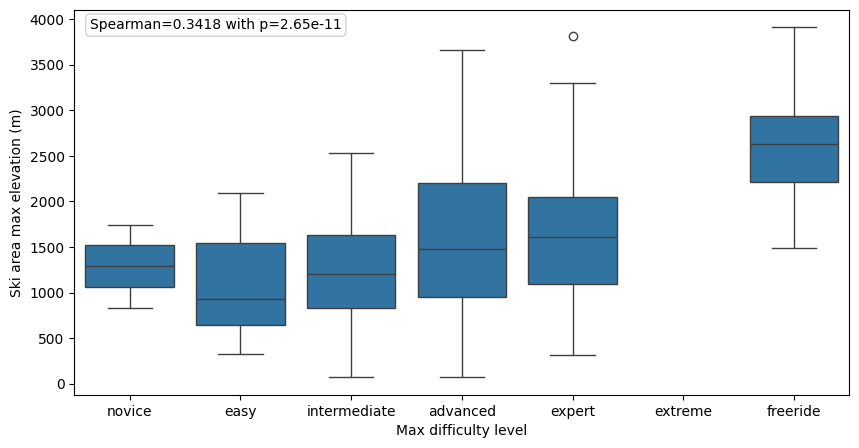

In [48]:
difficulty_values = {}
for value, target in enumerate(difficulty_order):
    difficulty_values[target] = value + 1

runs["difficulty_value"] = runs["difficulty"].map(difficulty_values)

mean_difficulty = runs.groupby("ski_area_names")["difficulty_value"].max()
ski_area_difficulty = ski_areas.merge(mean_difficulty, left_on="name", right_on="ski_area_names", how="inner")
ski_area_difficulty.rename(columns={"difficulty_value": "max_difficulty_value"}, inplace=True)

difficulty_remap = {}
for value, target in difficulty_values.items():
    difficulty_remap[target] = value

ski_area_difficulty["max_difficulty"] = ski_area_difficulty["max_difficulty_value"].map(difficulty_remap)

corr_spearman = sp.stats.spearmanr(ski_area_difficulty["max_elevation_m"], ski_area_difficulty["max_difficulty_value"])
print(f"Spearman: {corr_spearman[0]:.4f} with p={corr_spearman[1]:.2e}")

fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(data=ski_area_difficulty, x="max_difficulty", y="max_elevation_m", order=difficulty_order)
plt.xlabel("Max difficulty level")
plt.ylabel("Ski area max elevation (m)")
ax.annotate(f"Spearman={corr_spearman[0]:.4f} with p={corr_spearman[1]:.2e}", xy=(0.02, 0.96), xycoords='axes fraction', ha='left', va='center', bbox={'boxstyle': 'round', 'fc': 'white', 'ec': 'lightgrey'})
plt.savefig(max_difficulty_level_by_ski_area_elevation_path, bbox_inches='tight')
plt.show()

Qual è la distribuzione delle tipologie di seggiovie nei Paesi che hanno comprensori tipicamente più grandi e nei Paesi che hanno comprensori tipicamente più piccoli?

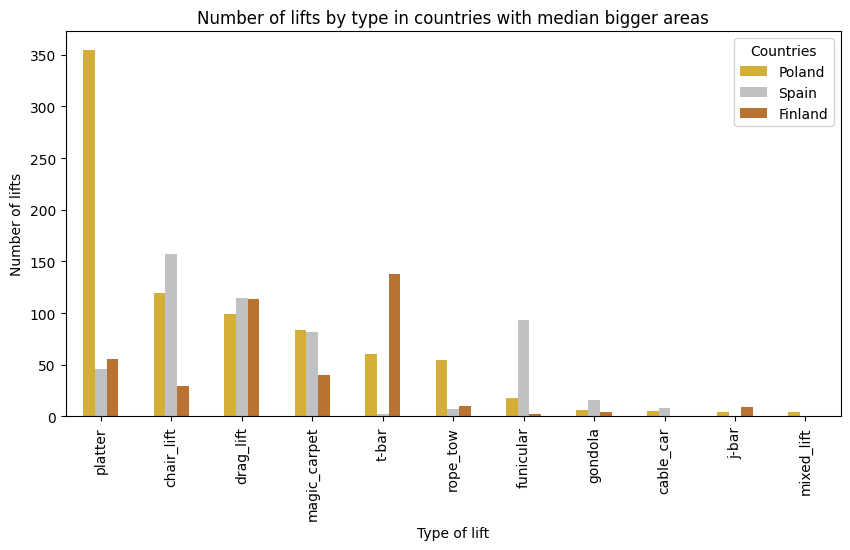

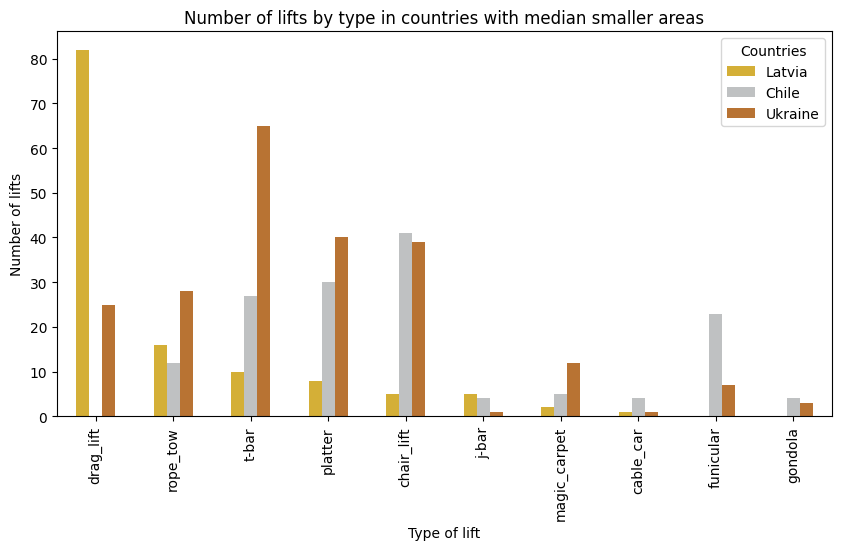

In [49]:
ski_areas["total_distance"] = ski_areas["downhill_distance_km"] + ski_areas["nordic_distance_km"]
countries_by_slopes_distance = ski_areas.groupby("countries")["total_distance"].median()

more_countries_by_slopes_distance = countries_by_slopes_distance.nlargest(3).index
less_countries_by_slopes_distance = countries_by_slopes_distance.nsmallest(3).index

more = list()
for index, country in enumerate(more_countries_by_slopes_distance):
    more.append(lifts[lifts["countries"] == more_countries_by_slopes_distance[index]])

more_lifts = list()
for index, country in enumerate(more):
    more_lifts.append(more[index].groupby("lift_type")["countries"].count().sort_values(ascending=False))

more_lifts = pd.concat([lift for lift in more_lifts], axis=1)
more_lifts.columns =  more_countries_by_slopes_distance
more_lifts = more_lifts.fillna(0)

less = list()
for index, country in enumerate(less_countries_by_slopes_distance):
    less.append(lifts[lifts["countries"] == less_countries_by_slopes_distance[index]])

less_lifts = list()
for index, country in enumerate(less):
    less_lifts.append(less[index].groupby("lift_type")["countries"].count().sort_values(ascending=False))

less_lifts = pd.concat([lift for lift in less_lifts], axis=1)
less_lifts.columns =  less_countries_by_slopes_distance
less_lifts = less_lifts.fillna(0)

palette = ["#D4AF37", "#BFC1C2", "#B87333"]

fig, ax = plt.subplots(figsize = (10, 5))
more_lifts.plot(kind="bar", ax=ax, color=palette)
ax.legend(title="Countries")
ax.set_xlabel("Type of lift")
ax.set_ylabel("Number of lifts")
ax.set_title("Number of lifts by type in countries with median bigger areas")
fig.savefig(number_of_lifts_by_type_coutry_with_bigger_areas_path, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize = (10, 5))
less_lifts.plot(kind="bar", ax=ax, color=palette)
ax.legend(title="Countries")
ax.set_xlabel("Type of lift")
ax.set_ylabel("Number of lifts")
ax.set_title("Number of lifts by type in countries with median smaller areas")
fig.savefig(number_of_lifts_by_type_coutry_with_smaller_areas_path, bbox_inches='tight')
plt.show()
